In [11]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [12]:
!ls drive/MyDrive/zs/

test_file.csv  train_file.csv


In [14]:
%cd drive/MyDrive/zs/

/content/drive/MyDrive/zs


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.externals import joblib 
import nltk
from nltk.corpus import stopwords
import re
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
stop_words = STOP_WORDS
import string
punctuations = string.punctuation
from sklearn.feature_extraction.text import HashingVectorizer

In [17]:
train = pd.read_csv('/content/drive/MyDrive/zs/train_file.csv')
test = pd.read_csv('/content/drive/MyDrive/zs/test_file.csv')

In [18]:
train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084


In [19]:
test.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn
0,tFrqIR6Chj,Sliding Economy: FG fights back with N3trn TSA...,With the 2016 budget now passed by the Nationa...,BusinessDay,economy,2016-03-29 01:41:12,0,0,1
1,DVAaGErjlF,Microsoft shows how HoloLens can bring distant...,A recent Microsoft Research video shows how th...,Daily Mail,microsoft,2016-03-29 01:41:27,121,2,13
2,OT9UIZm5M2,"Microsoft’s Twitter Robot Praises Hitler, Trum...",* Microsoft teamed with Bing to create TayTwee...,EURweb,microsoft,2016-03-29 01:47:00,12,1,0
3,lflGp3q2Fj,Flood of Central Bank Moves Can't Get World Ec...,Central bankers have managed to steer the worl...,Bloomberg via Yahoo! Finance,economy,2016-03-29 02:00:00,0,0,3
4,zDYG0SoovZ,USD/JPY: bears lining up on mixed U.S. economy...,"However, this streak of seven-day gains might ...",FXStreet,economy,2016-03-29 02:01:07,3,0,0


In [21]:
missing_val = pd.DataFrame(train.isnull().sum())
missing_val = missing_val.reset_index()
missing_val

,index,0
0,IDLink,0
1,Title,0
2,Headline,0
3,Source,175
4,Topic,0
5,PublishDate,0
6,Facebook,0
7,GooglePlus,0
8,LinkedIn,0
9,SentimentTitle,0


In [22]:
train[train['Source'].isna()]

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
6,lKg2pImhCl,"Monday, 29 Feb 2016","RAMALLAH, February 25, 2016 (WAFA) - Palestine...",NaN,palestine,2016-02-28 14:03:00,0,0,0,0.000000,-0.005906
56,ZOKue2cqfO,"Monday, 29 Feb 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 09:29:00,0,0,0,0.000000,0.048546
111,JXfRvxs0R6,"Tuesday, 1 Mar 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 00:15:00,0,0,0,-0.243068,0.048546
350,A1YOXDsuOO,Human rights situation in Palestinian territor...,In a special meeting convened by the UN Human ...,NaN,palestine,2015-10-28 17:24:00,-1,-1,-1,-0.228299,-0.124931
409,fO2mYsUg5P,Japan Contributes $5.73M To UNRWA’s Food Assis...,"JERUSALEM, October 31, 2015 (WAFA) – The Japan...",NaN,palestine,2015-10-31 04:30:00,-1,-1,-1,0.166667,-0.042878
...,...,...,...,...,...,...,...,...,...,...,...
55482,FJZonPtvqe,"Monday, 28 Mar 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 04:35:00,0,0,0,-0.243068,0.068465
55483,NanKfuNzsO,"Saturday, 16 Apr 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 04:36:00,-1,-1,-1,0.000000,0.068465
55486,ovFBb4XFt4,"Sunday, 17 Apr 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 05:07:00,-1,-1,-1,0.000000,0.068465
55620,H2PlLqiX9U,"Tuesday, 29 Mar 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 14:06:00,0,0,0,-0.243068,0.068465


In [23]:
train.dropna(inplace=True)

In [35]:
sns.set(style='whitegrid',palette='Set1')

AttributeError: ignored

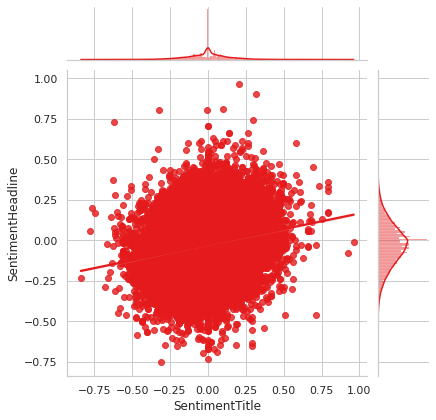

In [36]:
_ = sns.jointplot(x='SentimentTitle',y='SentimentHeadline',data=train,kind = 'reg')
_.annotate(stats.pearsonr)
plt.show()

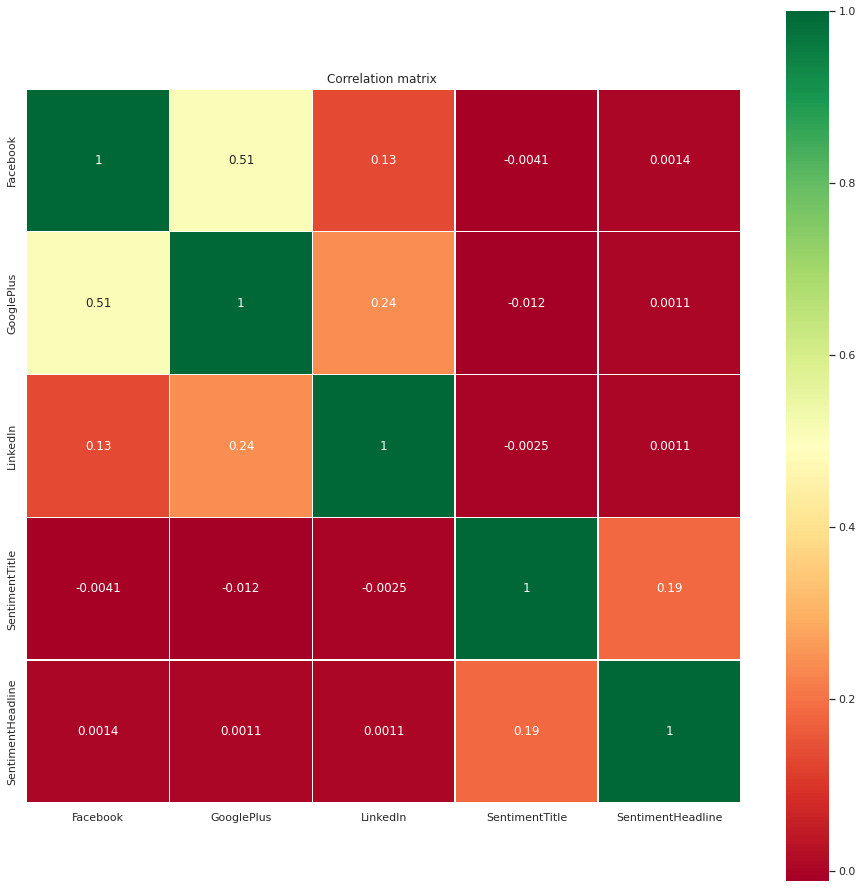

In [37]:
plt.figure(figsize=(16,16))
_ = sns.heatmap(train[['Facebook','GooglePlus','LinkedIn','SentimentTitle','SentimentHeadline']].corr(), square=True, cmap='RdYlGn',linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')

plt.show()

In [38]:
nlp = English()


In [39]:
def spacy_tokenizer(sentence):
    
    mytokens = nlp(sentence)   
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    return mytokens

In [40]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        
        return [clean_text(text) for text in X]

    def fit(self, X, y, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


def clean_text(text):
   
    return text.strip().lower()


In [42]:
bow_vector = CountVectorizer(max_features = 100,tokenizer = spacy_tokenizer,ngram_range=(1,2))

In [43]:
X_train_title = train.loc[:,'Title'].values
y_train_title = train.loc[:,['SentimentTitle']].values

X_train_headline = train.loc[:,'Headline'].values
y_train_headline = train.loc[:,['SentimentHeadline']].values

In [44]:
X_test_title = test.loc[:,'Title'].values
X_test_headline = test.loc[:,'Headline'].values

In [45]:
from sklearn.model_selection import train_test_split
x_train_title, x_valid_title, Y_train_title, y_valid_title = train_test_split(X_train_title, y_train_title, shuffle = True, test_size = 0.1)
x_train_headline, x_valid_headline, Y_train_headline, y_valid_headline = train_test_split(X_train_headline, y_train_headline, shuffle = True, test_size = 0.1)

In [46]:
abs_y_train_title=np.sign(Y_train_title)
abs_y_train_headline=np.sign(Y_train_headline)
abs_y_valid_title=np.sign(y_valid_title)
abs_y_valid_headline=np.sign(y_valid_headline)

In [47]:
xgboost = MultiOutputRegressor(XGBRegressor())
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=None,
                                                          random_state=0))

In [48]:
pipe1 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', regr_multirf)])

pipe2 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', regr_multirf)])

In [49]:
pipe1.fit(x_train_title,Y_train_title)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f917eb56990>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=100, min_df=1, ngram_range=(1, 2),
                                 preprocessor=None, stop_words=None,
                                 strip_accents=None,
                                 to...
                 MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                                      ccp_alpha=0.0,
                                                                      criterion='mse',
                                                                      max_depth=None,
      

In [50]:
pipe2.fit(x_train_headline,Y_train_headline)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f917eb56450>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=100, min_df=1, ngram_range=(1, 2),
                                 preprocessor=None, stop_words=None,
                                 strip_accents=None,
                                 to...
                 MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                                      ccp_alpha=0.0,
                                                                      criterion='mse',
                                                                      max_depth=None,
      

In [51]:
test_pred_title=pipe1.predict(x_valid_title)

In [52]:
test_pred_headline=pipe2.predict(x_valid_headline)

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [54]:
mae_title=mean_absolute_error(y_valid_title,test_pred_title)

In [55]:
mae_headline=mean_absolute_error(y_valid_headline,test_pred_headline)

In [56]:
score=1-((0.4*mae_title)+(0.6*mae_headline))

In [57]:
score

0.8987930170693771

In [58]:
pred_title=pipe1.predict(X_test_title)

In [59]:
pred_headline=pipe2.predict(X_test_headline)

In [60]:
submission=pd.DataFrame()

In [69]:
submission['IDLink']=test['IDLink'].to_list()
submission['SentimentTitle']=pred_title
submission['SentimentHeadline']=pred_headline

In [65]:
submission.head()

,IDLink,SentimentTitle,SentimentHeadline
0,tFrqIR6Chj,-0.029786,-0.015312
1,DVAaGErjlF,-0.017265,-0.042925
2,OT9UIZm5M2,-0.017265,-0.035235
3,lflGp3q2Fj,0.027624,-0.033447
4,zDYG0SoovZ,-0.154440,-0.009492


In [72]:
submission.to_csv('/content/drive/MyDrive/zs/sample_submissions.csv',index=False)